In [ ]:
import os
import cv2
import tensorflow as tf
import torch
from torch import nn
from PIL import Image
import numpy as np
import pandas as pd
import keras
pd.options.display.float_format = '{:.2f}'.format
import math
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
from tensorflow.keras.losses import BinaryCrossentropy
from matplotlib import pyplot as plt

Create training dataset.

In [ ]:
train_image_folder_path = '/content/drive/MyDrive/book_covers/train/images'

In [ ]:
train_image_files = [f for f in os.listdir(train_image_folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

In [ ]:
# Custom function to load and preprocess images
def load_and_preprocess_image(image_folder_path, file_path, target_size=(128, 128)):
    img = cv2.imread(os.path.join(image_folder_path, file_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)  # Resize to a fixed size
    img = img / 255
    # Normalize to be between -1 and 1 to be consistent with tanh activation in generator
    return 2*img - 1

In [ ]:
# Preprocess all images and store them in a NumPy array
train_processed_images = [load_and_preprocess_image(train_image_folder_path, file) for file in train_image_files]
train_processed_images = np.array(train_processed_images)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_processed_images)
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(128)

Initialise optimisers and loss functions.

In [ ]:
g_opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
d_opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
# GAN custom class with modified training step
class GAN(tf.keras.models.Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 512, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.ones_like(yhat_real), tf.zeros_like(yhat_fake)], axis=0)
            
            # Add noise to labels to improve training results
            noise_real = -0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,512,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

Going to try use a pre-trained discriminator

In [ ]:
# going to use best generator I have so far with the pre-trained discriminator
generator = keras.models.load_model('/content/drive/MyDrive/book_covers/generator10.keras')

In [ ]:
base_model = VGG16(input_shape = (128, 128, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet',
classifier_activation='sigmoid')

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

In [ ]:
gan = GAN(generator, model)

gan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
hist = gan.fit(train_dataset, epochs=350)

Epoch 1/350
39/39 [==============================] - 57s 815ms/step - d_loss: 0.3851 - g_loss: 2.3862
Epoch 2/350
39/39 [==============================] - 28s 717ms/step - d_loss: 0.2993 - g_loss: 2.8267
Epoch 3/350
39/39 [==============================] - 28s 717ms/step - d_loss: 0.2813 - g_loss: 2.6892
Epoch 4/350
39/39 [==============================] - 28s 719ms/step - d_loss: 0.2774 - g_loss: 2.7101
Epoch 5/350
39/39 [==============================] - 28s 720ms/step - d_loss: 0.2760 - g_loss: 2.6907
Epoch 6/350
39/39 [==============================] - 28s 721ms/step - d_loss: 0.2743 - g_loss: 2.6459
Epoch 7/350
39/39 [==============================] - 28s 721ms/step - d_loss: 0.2757 - g_loss: 2.2905
Epoch 8/350
39/39 [==============================] - 28s 721ms/step - d_loss: 0.2718 - g_loss: 2.3577
Epoch 9/350
39/39 [==============================] - 28s 720ms/step - d_loss: 0.2712 - g_loss: 2.4960
Epoch 10/350
39/39 [==============================] - 28s 722ms/step - d_loss: 0.2

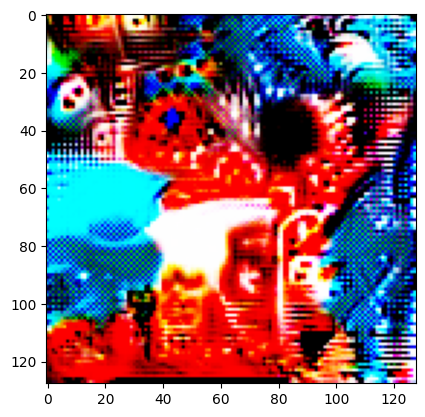

In [ ]:
noise = np.random.randn(10, 512)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0])